# Problem 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# MODULES


# Model architecture
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1_out, ch3x3_out):
        super().__init__()
        self.branch1x1 = ConvModule(in_channels, ch1x1_out, 1, 1)
        self.branch3x3 = ConvModule(in_channels, ch3x3_out, 3, 1)

    def forward(self, x):
        return torch.cat([self.branch1x1(x), self.branch3x3(x)], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, ch3x3_out):
        super().__init__()
        self.branch3x3 = ConvModule(in_channels, ch3x3_out, 3, 2)
        self.branch_pool = nn.MaxPool2d(3, 2, 1)

    def forward(self, x):
        return torch.cat([self.branch3x3(x), self.branch_pool(x)], 1)


class InceptionSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            ConvModule(3, 96, 3, 1),
            InceptionModule(96, 32, 32),
            InceptionModule(64, 32, 48),
            DownsampleModule(80, 80),
            InceptionModule(160, 112, 48),
            InceptionModule(160, 96, 64),
            InceptionModule(160, 80, 80),
            InceptionModule(160, 48, 96),
            DownsampleModule(144, 96),
            InceptionModule(240, 176, 160),
            InceptionModule(336, 176, 160),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Dropout(), nn.Linear(336, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# prepare data
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

batch_size = 64
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

# init loss
model = InceptionSmall(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

Using device: cpu


100%|██████████| 26421880/26421880 [00:09<00:00, 2725081.99it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 332080.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1233442.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1220178.40it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Problem 3.1

Learning rate range test

In [2]:
# Part 1: learning rate range test
lr_start = 1e-9
lr_end = 1e1
num_epochs = 5
total_steps = len(train_loader) * num_epochs

learning_rates = []
train_losses = []

model.train()

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Adjust learning rate
        current_step = epoch * len(train_loader) + batch_idx
        lr = lr_start + (lr_end - lr_start) * current_step / total_steps
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        learning_rates.append(lr)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        train_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# plot the test results
plt.figure()
plt.plot(learning_rates, train_losses)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Learning Rate")
plt.grid(True)
plt.show()


Epochs:  40%|████      | 2/5 [37:11<55:47, 1115.77s/it]


KeyboardInterrupt: 

In [6]:
# optimal values from the plot
lrmin = 1e-3
lrmax = 1e-1

## Problem 3.2

Cyclical Learning Rate

Epoch 1/5: 100%|██████████| 938/938 [00:45<00:00, 20.73it/s]


Epoch [1/5], Train Loss: 0.5290, Train Acc: 81.38%, Val Loss: 0.3614, Val Acc: 87.31%


Epoch 2/5: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


Epoch [2/5], Train Loss: 0.3016, Train Acc: 89.35%, Val Loss: 0.3533, Val Acc: 87.19%


Epoch 3/5: 100%|██████████| 938/938 [00:44<00:00, 20.96it/s]


Epoch [3/5], Train Loss: 0.2462, Train Acc: 91.16%, Val Loss: 0.2518, Val Acc: 90.51%


Epoch 4/5: 100%|██████████| 938/938 [00:44<00:00, 20.90it/s]


Epoch [4/5], Train Loss: 0.1917, Train Acc: 93.14%, Val Loss: 0.2007, Val Acc: 92.68%


Epoch 5/5: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


Epoch [5/5], Train Loss: 0.1421, Train Acc: 95.03%, Val Loss: 0.1739, Val Acc: 93.68%


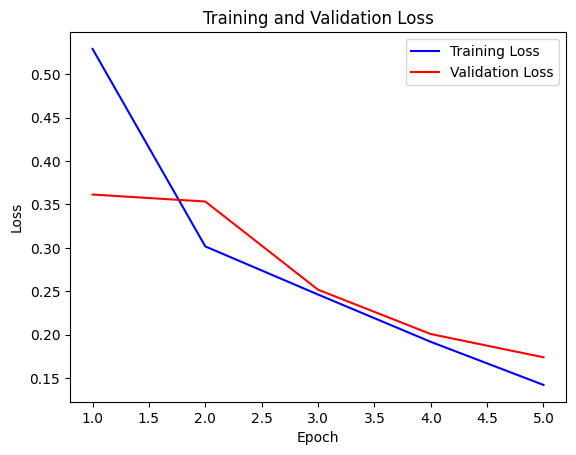

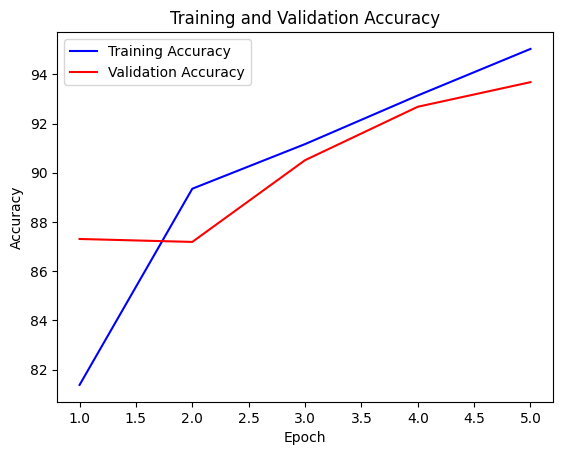

In [9]:
model = InceptionSmall(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=lrmin, momentum=0.9)
criterion = nn.CrossEntropyLoss()


# Training parameters
num_epochs = 5
total_steps = num_epochs * len(train_loader)
scheduler = CyclicLR(
    optimizer,
    base_lr=lrmin,
    max_lr=lrmax,
    step_size_up=total_steps // 2,
    mode="exp_range",
    gamma=0.99994,
)

# Metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass and loss computation
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate training loss and accuracy
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    # Compute epoch training loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            # Accumulate validation loss and accuracy
            val_running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    # Compute validation loss and accuracy
    val_loss = val_running_loss / len(test_loader.dataset)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Logging the metrics
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

# Plotting the results
epochs = range(1, num_epochs + 1)

# Loss Plot
plt.figure(figsize=(12, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, "b-", label="Training Loss", linewidth=2)
plt.plot(epochs, val_losses, "r-", label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)

# Training and Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, "b-", label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_accuracies, "r-", label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

## Problem 3.3

Testing with different batch sizes

Batch Size 2048:  30%|███       | 30/100 [00:51<02:01,  1.73s/it]


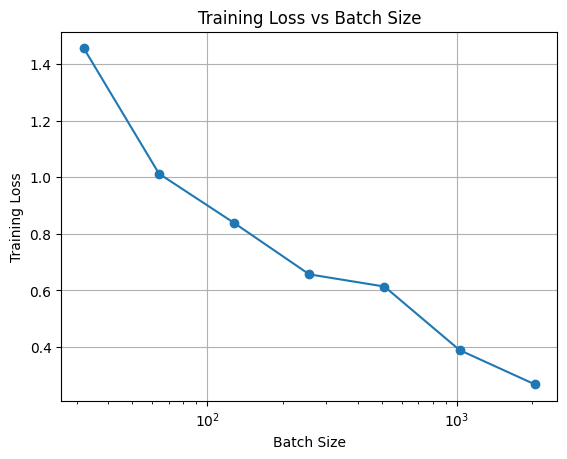

In [10]:
def batch_size_test(train_dataset, test_loader, lr_max):
    batch_sizes = [
        32,
        64,
        128,
        256,
        512,
        1024,
        2048,
    ]  # T4 GPU with 16GB ram on Google colab can't handle more than this
    train_losses_batch = []
    val_accuracies_batch = []
    num_epochs = 1  # Fixed number of epochs to ensure equal data exposure

    for batch_size in batch_sizes:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
        )
        model = InceptionSmall(num_classes=10).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        model.train()
        running_loss = 0.0
        total_samples = 0

        # Train for a fixed number of epochs
        for epoch in range(num_epochs):
            progress_bar = tqdm(
                train_loader, desc=f"Batch Size {batch_size}, Epoch {epoch + 1}"
            )
            for data, target in progress_bar:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * data.size(0)
                total_samples += data.size(0)

        epoch_loss = running_loss / total_samples
        train_losses_batch.append(epoch_loss)

        # Evaluate on validation set
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        val_accuracy = 100 * val_correct / val_total
        val_accuracies_batch.append(val_accuracy)
        print(
            f"Batch Size {batch_size}, Training Loss: {epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
        )

    # Plot Training Loss vs Batch Size
    plt.figure(figsize=(8, 6))
    plt.plot(
        batch_sizes,
        train_losses_batch,
        marker="o",
        color="red",
        linestyle="-",
        linewidth=2,
        markersize=8,
    )
    plt.xscale("log")
    plt.xlabel("Batch Size", fontsize=14)
    plt.ylabel("Training Loss", fontsize=14)
    plt.title("Training Loss vs Batch Size", fontsize=16)
    plt.grid(True, which="both", linestyle="--", linewidth=0.7)
    plt.tight_layout()
    plt.show()


batch_size_test(train_dataset, test_loader, lrmax)